
# 2.2-kW PMSM, 2-mass mechanics

This example simulates observer-based V/Hz control of a 2.2-kW PMSM drive. The
mechanical subsystem is modeled as a two-mass system. The resonance frequency
of the mechanics is around 85 Hz. The mechanical parameters except that the torsional damping is set to a smaller value in
this example.


In [1]:
pip install motulator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 3.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from motulator.drive import model
import motulator.drive.control.sm as control
from motulator.drive.utils import (
    BaseValues, NominalValues, plot, Sequence, SynchronousMachinePars,
    TwoMassMechanicalSystemPars)

Compute base values based on the nominal values (just for figures).



In [3]:
nom = NominalValues(U=370, I=4.3, f=75, P=2.2e3, tau=14)
base = BaseValues.from_nominal(nom, n_p=3)

Configure the system model.



In [4]:
mdl_par = SynchronousMachinePars(
    n_p=3, R_s=3.6, L_d=.036, L_q=.051, psi_f=.545)
machine = model.SynchronousMachine(mdl_par)
mdl_mec_par = TwoMassMechanicalSystemPars(J_M=.005, J_L=.005, K_S=700, C_S=.01)
mechanics = model.TwoMassMechanicalSystem(mdl_mec_par)
converter = model.VoltageSourceConverter(u_dc=540)
mdl = model.Drive(converter, machine, mechanics)

Configure the control system.



In [5]:
par = mdl_par  # Assume accurate machine model parameter estimates
cfg = control.ObserverBasedVHzControlCfg(par, max_i_s=1.5*base.i)
ctrl = control.ObserverBasedVHzControl(par, cfg, T_s=250e-6)
#ctrl.rate_limiter = control.RateLimiter(2*np.pi*120)

Set the speed reference and the external load torque.



In [6]:
# Speed reference
times = np.array([0, .1, .2, 1])
values = np.array([0, 0, 1, 1])*base.w*.5
ctrl.ref.w_m = Sequence(times, values)
# External load torque
times = np.array([0, .4, .4, 1])
values = np.array([0, 0, 1, 1])*nom.tau
mdl.mechanics.tau_L = Sequence(times, values)

Create the simulation object and simulate it.



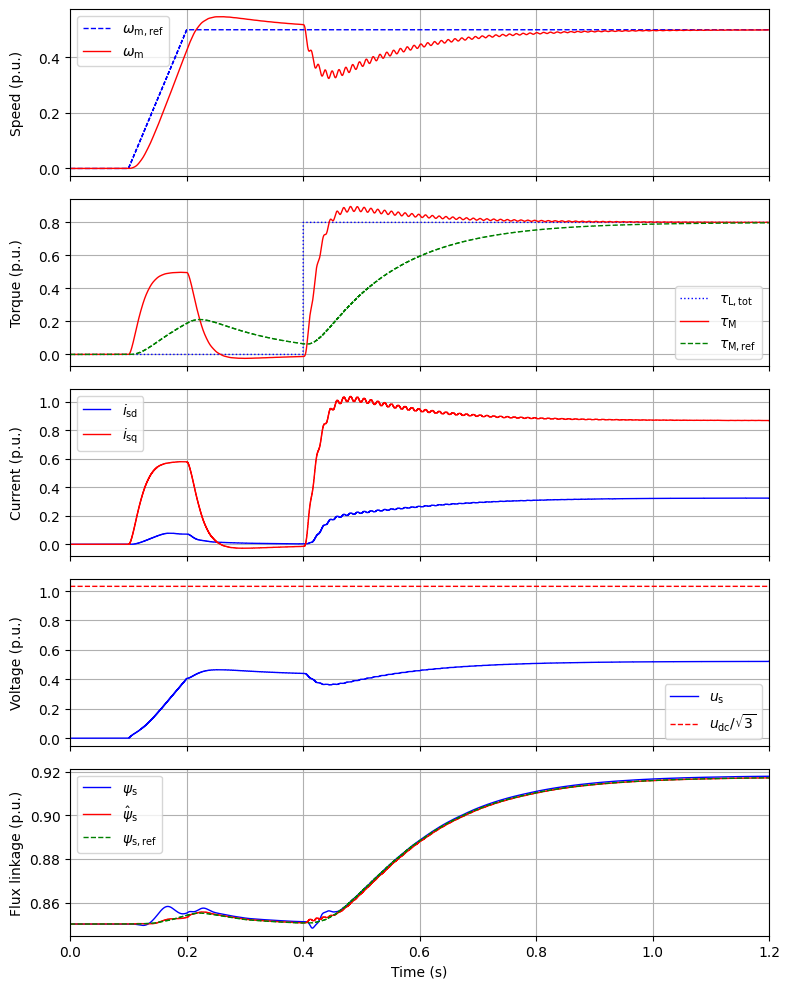

In [7]:
sim = model.Simulation(mdl, ctrl)
sim.simulate(t_stop=1.2)
# sphinx_gallery_thumbnail_number = 3
plot(sim, base)  # Plot results in per-unit values

Plot the load speed and the twist angle.



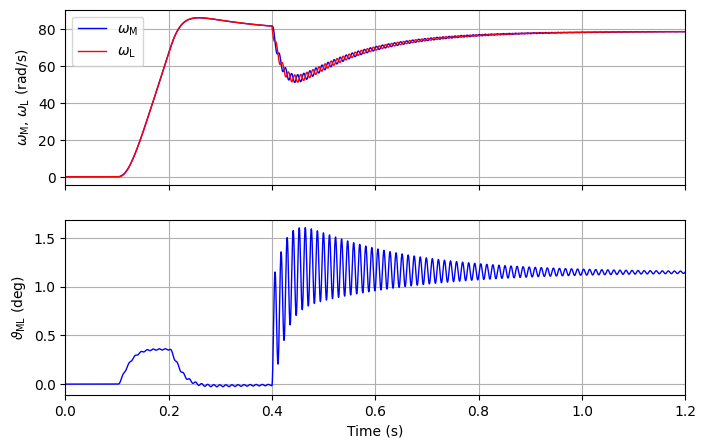

In [8]:
t_span = (0, 1.2)
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5))
ax1.plot(
    sim.mdl.mechanics.data.t,
    sim.mdl.mechanics.data.w_M,
    label=r"$\omega_\mathrm{M}$")
ax1.plot(
    sim.mdl.mechanics.data.t,
    sim.mdl.mechanics.data.w_L,
    label=r"$\omega_\mathrm{L}$")
ax2.plot(sim.mdl.mechanics.data.t, sim.mdl.mechanics.data.theta_ML*180/np.pi)
ax1.set_xlim(t_span)
ax2.set_xlim(t_span)
ax1.set_xticklabels([])
ax1.legend()
ax1.set_ylabel(r"$\omega_\mathrm{M}$, $\omega_\mathrm{L}$ (rad/s)")
ax2.set_ylabel(r"$\vartheta_\mathrm{ML}$ (deg)")
ax2.set_xlabel("Time (s)")
plt.show()

Plot also the frequency response from the electromagnetic torque tau_M to the
rotor speed w_M.



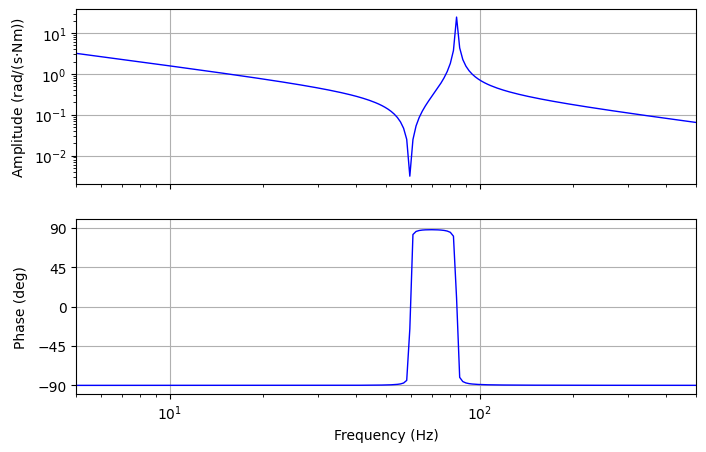

In [9]:
# Frequency range and number of points
f_span = (5, 500)
num = 200
# Parameters
J_M, J_L = mdl_mec_par.J_M, mdl_mec_par.J_L
K_S, C_S = mdl_mec_par.K_S, mdl_mec_par.C_S
# Frequencies
w = 2*np.pi*np.logspace(np.log10(f_span[0]), np.log10(f_span[-1]), num=num)
s = 1j*w
# Frequency response
B = J_L*s**2 + C_S*s + K_S
A = s*(J_M*J_L*s**2 + (J_M + J_L)*C_S*s + (J_M + J_L)*K_S)
G = B/A
# Plot figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5))
ax1.loglog(w/(2*np.pi), np.abs(G))
ax1.set_xticklabels([])
ax2.semilogx(w/(2*np.pi), np.angle(G)*180/np.pi)
ax1.set_xlim(f_span)
ax2.set_xlim(f_span)
ax2.set_ylim([-100, 100])
ax2.set_yticks([-90, -45, 0, 45, 90])
ax1.set_ylabel(r"Amplitude (rad/(s$\cdot$Nm))")
ax2.set_ylabel("Phase (deg)")
ax2.set_xlabel("Frequency (Hz)")
fig.align_ylabels()
plt.show()

.. rubric:: References

.. [#Saa2015] Saarakkala, Hinkkanen, "Identification of two-mass mechanical
   systems using torque excitation: Design and experimental evaluation," IEEE
   Trans. Ind. Appl., 2015, https://doi.org/10.1109/TIA.2015.2416128

